# 顔文字生成器（サンプル）
単純ニューラルネットワークだけのシンプル構成  
系列データを1次元にまとめて計算させる

In [1]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 51.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=f2607298c47cb353270dc55093c52daaceaa63fab6ae57639cc55abd3d79bd2a
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

from sklearn.manifold import TSNE

## 前処理

### データ読み込み

In [3]:
# 特殊文字
sp = {'pad': '<PAD>',
      # 'bos': '<BOS>',
      # 'eos': '<EOS>',
      'unk': '<UNK>'}
# pad : padding. 文字列長を一定にするために使う
# bos : begin of sequence. 文頭文字．Decoderの最初の入力
# eos : end of sequence. 文末文字．
# unk : unknown. 出現数が低いものに割り当てる

In [4]:
sp.values()

dict_values(['<PAD>', '<UNK>'])

In [5]:
KAOMOJI_MAX = 10    # 顔文字最大長

kmj_list = []   # 顔文字リスト
len_list = []       # <BOS> から <EOS> までの文字数のリスト
char_list = []      # 顔文字に使用されている文字のリスト

char_list += list(sp.values())
file_name = 'kaomoji_MAX=' + str(KAOMOJI_MAX) + '.txt'

with open(file_name, mode='r') as file:
  for line in file:
    # temp = [sp['bos']]
    temp = list(line.replace('\n', ''))
    # temp += [sp['eos']]
    len_list.append(len(temp))
    temp += [sp['pad'] for _ in range(KAOMOJI_MAX - len(temp))]
    kmj_list.append(temp)
    char_list += temp

# 重複を消す
char_list = sorted(set(char_list), key=char_list.index)

In [6]:
print(kmj_list[0])

['(', '(', '(', '\u3000', '̄', 'ー', '\u3000', '̄', '\u3000', ')']


In [7]:
print('Number of kaomoji  :', len(kmj_list))
print('Number of character:', len(char_list))

Number of kaomoji  : 5457
Number of character: 719


### 出現数が少ないものを置換

In [8]:
# 最小出現数
MIN_APPEAR = 20

kmj_list = np.array(kmj_list)

cnt = 0
for c in char_list:
  mask = (kmj_list == c)
  if np.sum(mask) < MIN_APPEAR:
    kmj_list[mask] = sp['unk']

char_list = list(sp.values()) + kmj_list.flatten().tolist()
char_list = sorted(set(char_list), key=char_list.index)

In [9]:
print('Number of character:', len(char_list))

Number of character: 137


### 添字検索
顔文字に使われる文字が文字リストの何番目にあるか調べる

In [10]:
kmj_index = []    # 添字リスト

for kmj in kmj_list.tolist():
  temp = [char_list.index(c) for c in kmj]
  kmj_index.append(temp)

In [11]:
print(len_list[0])
kmj_index[0]

10


[2, 2, 2, 3, 4, 5, 3, 4, 3, 6]

### One-hotベクトル化



In [12]:
kmj_num = len(kmj_index)        # 顔文字の総数
kmj_size = len(kmj_index[0])    # 1つの顔文字の長さ
char_num = len(char_list)       # 文字の種類数

# One-hotベクトルリスト
kmj_onehot = np.zeros((kmj_num, kmj_size, char_num))

for i, index in enumerate(kmj_index):
  mask = range(char_num) == np.array(index).reshape((kmj_size, 1))
  kmj_onehot[i][mask] = 1

In [13]:
kmj_onehot.shape

(5457, 10, 137)

### 訓練・検証・テスト用に分ける

In [14]:
dataset = torch.utils.data.TensorDataset(
  torch.tensor(kmj_onehot.astype('float32')),
  torch.tensor(len_list)
)

In [15]:
train_size = int(len(dataset) * 0.85)
valid_size = int(len(dataset) * 0.10)
test_size  = len(dataset) - train_size - valid_size

# indices = np.arange(len(dataset))

# dataset_train = torch.utils.data.Subset(dataset, indices[:train_size])
# dataset_valid = torch.utils.data.Subset(dataset, indices[train_size:train_size+valid_size])
# dataset_test  = torch.utils.data.Subset(dataset, indices[train_size+valid_size:])

split = [train_size, valid_size, test_size]

dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, split)

In [16]:
dataset_train[0]

(tensor([[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 tensor(8))

In [17]:
batch_size = 32

dataloader_train = torch.utils.data.DataLoader(
  dataset_train,
  batch_size=batch_size,
  shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
  dataset_valid,
  batch_size=batch_size,
  shuffle=True
)

In [18]:
for x, len_seq in dataloader_train:
  print(x.shape, len_seq.shape)
  break

torch.Size([32, 10, 137]) torch.Size([32])


## モデル

### Encoder

In [740]:
class Encoder(nn.Module):
  def __init__(self, N, in_dim, emb_dim, hid_dim):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(in_dim, emb_dim),
      # nn.Sigmoid(),
      nn.Flatten(),
      nn.Linear(N*emb_dim, hid_dim),
      # nn.Sigmoid()
    )

  def forward(self, x):
    return self.net(x)

In [741]:
encoder = Encoder(20, 269, 16, 64)
x = torch.rand(32, 20, 269)
encoder(x).shape

torch.Size([32, 64])

### Decoder

In [742]:
class Decoder(nn.Module):
  def __init__(self, in_dim, hid_dim, out_dim):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(in_dim, hid_dim),
      nn.Sigmoid(),
      # nn.Linear(hid_dim, hid_dim),
      # nn.ReLU(),
      nn.Linear(hid_dim, out_dim),
    )

  def forward(self, x):
    return self.net(x)

In [743]:
decoder = Decoder(64, 64, 20*269)
x = torch.rand(32, 64)
decoder(x).shape

torch.Size([32, 5380])

### Generator

In [794]:
class Generator(nn.Module):
  def __init__(self, N, in_dim, emb_dim, hid_dim):
    super().__init__()
    self.N = N
    self.in_dim = in_dim
    self.encoder = Encoder(N, in_dim, emb_dim, hid_dim)
    self.decoder = Decoder(hid_dim, hid_dim, N*in_dim)

  def forward(self, x):
    z = self.encoder(x)
    y = self.decoder(z)
    return y.view(-1, self.N, self.in_dim)

In [783]:
generator = Generator(20, 269, 16, 64)
x = torch.rand(32, 20, 269)
generator(x).shape

torch.Size([32, 20, 269])

## 学習

In [784]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [795]:
n_epochs = 5

N = KAOMOJI_MAX
in_dim = len(char_list)
emb_dim = 8
hid_dim = 64

net = Generator(N, in_dim, emb_dim, hid_dim)

optimizer = optim.Adam(net.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [796]:
for epoch in range(n_epochs):
  losses_train = []
  losses_valid = []

  # 訓練
  net.train()
  for x, len_seq in dataloader_train:
    net.zero_grad()  # 勾配の初期化

    #x.to(device)
    #t.to(device)

    y = net(x)

    loss = criterion(y, x)
    loss.backward()  # 誤差の逆伝播
    losses_train.append(loss.tolist())

    optimizer.step()  # パラメータの更新

  # 検証
  net.eval()
  for x, len_seq in dataloader_valid:
    y = net(x)

    loss = criterion(y, x)
    losses_valid.append(loss.tolist())

  if (epoch+1) % 1 == 0:
    print('EPOCH: {:>2}, Train Loss: {:>4.5f}, Valid Loss: {:>4.5f}'.format(
        epoch,
        np.mean(losses_train),
        np.mean(losses_valid),
    ))

EPOCH:  0, Train Loss: 0.10246, Valid Loss: 0.07839
EPOCH:  1, Train Loss: 0.07195, Valid Loss: 0.06960
EPOCH:  2, Train Loss: 0.06269, Valid Loss: 0.06690
EPOCH:  3, Train Loss: 0.05701, Valid Loss: 0.06229
EPOCH:  4, Train Loss: 0.05309, Valid Loss: 0.06378


## 評価

In [787]:
def convert_str(x):
  x = np.array(char_list)[x.argmax(dim=1)]
  x = [c for c in x if c not in sp.values()]

  return ''.join(x)

def generate(net, base=None, rate=3.0):
  if base is None:
    z = 2*rate * torch.randn(1, hid_dim) - rate
  else:
    z = net.encoder(base.unsqueeze(0))
    eps = 2*rate * torch.rand(1, hid_dim) - rate
    z = z + eps

  y = net.decoder(z)
  gen = convert_str(y.view(KAOMOJI_MAX, len(char_list)))

  return ''.join(gen)

### 次元圧縮テスト
目標はbaseとgenerateで全く同じもの．
次元圧縮して，潜在ベクトルが獲得できているかどうかのテスト．

In [798]:
for i in np.random.randint(0, len(dataset_test), size=10):
  test = dataset_test[i][0]
  print('base     :', convert_str(test))
  print('generate :', generate(net, base=test, rate=0.0))

base     : (^・ω・^*)/
generate : (　̄ω・꒪;)
base     : ヾ(゚∀゚)ノ!
generate : Σ(゚ω゚)〃!
base     : ΣΣ(゚Д゚;):
generate : [!(≧ω≦̄)
base     : ~(□`)~
generate : Σ(∀`)!
base     : (*ё_ё*)・・
generate : (　╹ω`;)・
base     : !(　^-^　)
generate : Σ(　̄∀≦̄)
base     : (*　́∪`*)♪♪
generate : (*　́∀`̄)
base     : (　́_`。)
generate : (　̄∀`̄)
base     : (●`ω　́●)
generate : (*`∀　́;)
base     : (*'ー'*)ノ♪
generate : Σ(*゚∀≦̄)ノ


### 生成テスト
潜在ベクトルに乱数を入力しその出力を見る．

In [799]:
for _ in range(10):
  print('generate :', generate(net, base=None, rate=1.0))

generate : Σ(^ω゚;)ノ
generate : [(゚ε^　)　)
generate : (　̄ω≦̄)ノ
generate : Σ(^ε・　)!
generate : Σ(^ω　̄)~
generate : [(　̄　〃)
generate : Σ(^ε゚)〃!
generate : Σ(^ε゚)ノ
generate : (*　́　̄!
generate : Σ(^-◕))


### 類似度テスト
訓練データの中から潜在ベクトルの距離が近いものを見る．

In [790]:
def similar(net, base, num=10):
  z = net.encoder(base.unsqueeze(0))

  size = list(z.shape)
  size[0] = 0
  z_list = torch.empty(size, dtype=torch.float)
  z_list = net.encoder(dataset_train[:][0])

  diff = z_list - z
  norm = enumerate(torch.norm(diff, dim=1))
  norm = sorted(norm, key=lambda x: x[1])

  for i in range(num):
    min_index = norm[i][0]
    str = convert_str(dataset_train[min_index][0])
    print('{} : {}'.format(str, norm[i][1]))

In [805]:
i = np.random.randint(0, len(dataset_test))
test = dataset_test[i][0]
print(convert_str(test), ' : base')
similar(net, test, num=10)

ヾ(゚∀゚)ノ!  : base
ヾ(゚д゚)ノ! : 1.7025729417800903
ヾ(≧▽≦)ノ♪ : 2.002581834793091
ρ(^◇^)ノ! : 2.1467807292938232
「(゚∀゚)」! : 2.6149227619171143
∩(^∇^)∩♪ : 3.277379035949707
∑(゚Θ゚)!! : 3.6700637340545654
∑(゚Д゚)!? : 3.704618453979492
ヽ(・∀・)ノ♪ : 3.877681016921997
っ(≧ω≦)~♪ : 4.040196895599365
~(≧∇≦)~! : 4.129874229431152


### 潜在ベクトルの分布図
t-SNEという次元削減アルゴリズムがあるらしいので，それを使って潜在ベクトルを2次元化して表示

In [806]:
z_list = net.encoder(dataset_train[:][0]).detach().numpy()
z_reduc = TSNE(n_components=2).fit_transform(z_list).T

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8721 (\N{N-ARY SUMMATION}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


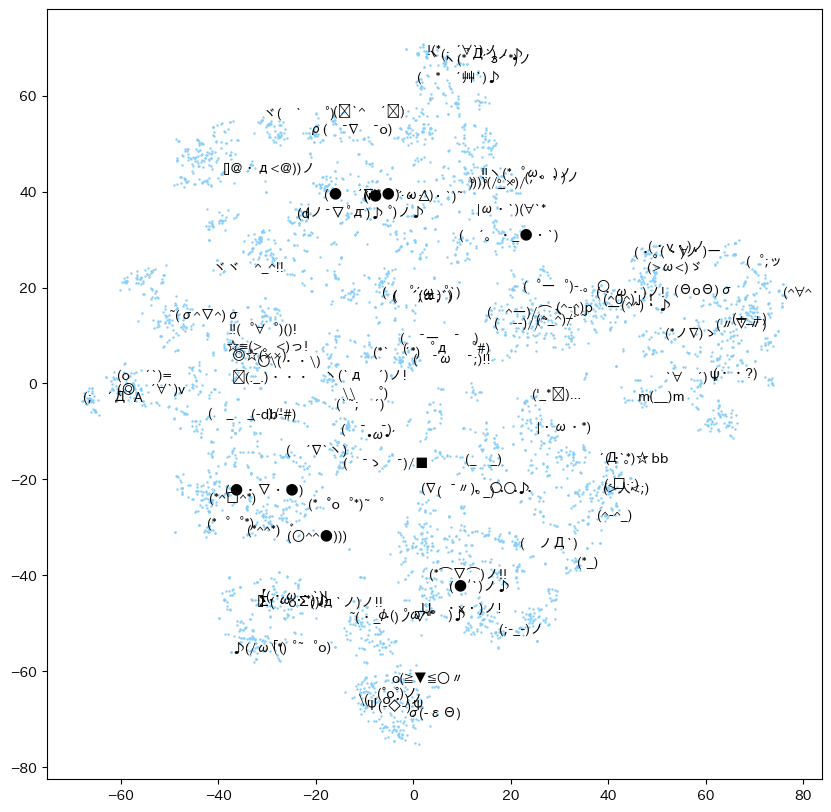

In [809]:
plt.figure(figsize=(10, 10))
plt.scatter(*z_reduc, s=0.5, c='lightskyblue')

for i in random.sample(range(len(dataset_train)), 100):
  plt.text(*z_reduc[:, i], convert_str(dataset_train[i][0]), fontsize=10)

plt.show()

## 感想

このネットワークは，  
Encoder：Embedding+Flatten+Linear  
Decoder：Linear  
の構成

入力系列のそれぞれのEmbeddingを無理矢理，平坦化して計算させる．

活性化関数はない方が良い？

体感，LSTMよりも性能が良さげ

